# SFC-PHY Mapping Problem | Python Edition

**== TRADE OFFER ==**

I receive: *a bunch of SFCs' Graph and one PHY Graph*

You receive: *__optimal mapping result__*

## Preparation
Install libraries, import libraries, initialize this and that, ... Such boring lines of codes...

In [1]:
# Preparation

# Install Required libraries
# %pip install networkx
# %pip install pulp

# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
import pulp as pulp
from pulp import *
import os

# Initialize
problemName = "SFC-PHY-mapping-4"
problem = LpProblem(problemName, LpMinimize)


if os.path.exists("./output"):
    for f in os.listdir("./output/"):
        os.remove(os.path.join("./output/", f))
else:
    try:
        os.mkdir("./output/")
    except OSError as error:
            print(error)
print("Output folder is now empty!")

Output folder is now empty!


In [2]:
# Assuming we already have a bunch of SFCs' Directed Graphs stored in a list()
SFCs = list()
for j in range(3):
    for i in range(3):
        SFCs.append(nx.read_gml(f"./inputs/sfc{i}.gml"))
# Assuming we already have a Directed Graph of PHY network
G = nx.read_gml("./inputs/phy.gml")

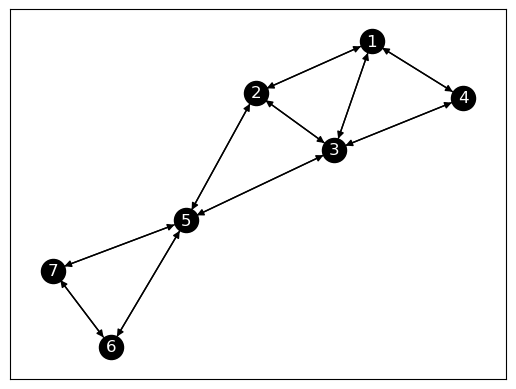

In [3]:
# Visualization
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, node_color='k', edge_color='k', font_color='w', with_labels=True)
plt.show()
for i in SFCs:
    # nx.draw_networkx(i, node_color='b', edge_color='b', font_color='w', with_labels=True)
    plt.show()

In [4]:
# Build Node Placement List
phiNode_S = list()
for sfc in SFCs:
    phiNode_S.append(
        LpVariable.dicts(
            name=f"phiNode_s{SFCs.index(sfc)}",
            indices=(sfc.nodes, G.nodes),
            cat = "Binary"
        )
    )

# Build Link Placement List
phiLink_S = list()
for sfc in SFCs:
    phiLink_S.append(
        LpVariable.dicts(
            name=f"phiLink_s{SFCs.index(sfc)}",
            indices=(sfc.edges, G.edges),
            cat="Binary"
        )
    )

phiSFC = LpVariable.dicts(
    name="phiSFC",
    indices=(range(len(SFCs))),
    cat="Binary"
)

## Constraints list
Attention: there are FIVE GROUPS of constraints.
$$ \sum_{s\in S}\sum_{v\in N_{s}}\phi_{i}^{v,s}.r_{v}\leq a_{i}\qquad\forall i\in\mathcal{N} \qquad \text{(C1)} $$
$$ \sum_{s\in S}\sum_{vw\in E_{s}}\phi_{ij}^{vw,s}.r_{vw}\leq a_{ij}\qquad\forall ij\in\mathcal{E} \qquad \text{(C2)} $$
$$ \sum_{v\in\mathcal{N}_{s}}\phi_{i}^{v,s}\leq1\qquad\forall i\in\mathcal{N},\forall s\in\mathcal{S} \qquad \text{(C3)} $$
$$ \sum_{i\in\mathcal{N}}\phi_{i}^{v,s}=\phi^{s}\qquad\forall v\in\mathcal{N}_{s},\forall s\in\mathcal{S} \qquad \text{(C4)} $$
$$ \sum_{j\in N}\phi_{ij}^{vw,s}-\sum_{j\in N}\phi_{ji}^{vw,s}=\phi_{i}^{v,s}-\phi_{i}^{w,s}\qquad\forall i\in\mathcal{N},\forall vw\in\mathcal{E}_{s},\forall s\in\mathcal{S} \qquad \text{(C5)} $$

In [5]:
# Bulding Constraints
problem.constraints.clear()

## C1
for node in G.nodes:
    problem += (
        lpSum(
            lpSum(
                phiNode_S[SFCs.index(sfc)][node_S][node] * nx.get_node_attributes(sfc, "Requirement")[node_S]
                    for node_S in sfc.nodes
            ) 
            for sfc in SFCs
        )
            <= nx.get_node_attributes(G, "Capacity"), 
            f"C1_i{node}"
    )

## C2
for edge in G.edges:
    problem += (
        lpSum(
            lpSum(
                phiLink_S[SFCs.index(sfc)][link_S][edge] * nx.get_edge_attributes(sfc, "Requirement")[link_S]
                for link_S in sfc.edges
            ) 
            for sfc in SFCs
        )
            <= nx.get_edge_attributes(G, "Capacity"), 
        f"C2_ij{edge}"
    )

## C3
for sfc in SFCs:
    for node in G.nodes:
        problem += (
            lpSum(
                phiNode_S[SFCs.index(sfc)][node_S][node]
                for node_S in sfc.nodes
            )
            <= 1
            ,
            f"C3_i{node}_s{SFCs.index(sfc)}"
        )

## C4
for sfc in SFCs:
    for node_S in sfc.nodes:
        problem += (
            lpSum(
                phiNode_S[SFCs.index(sfc)][node_S][node]
                for node in G.nodes
            )
            == phiSFC[SFCs.index(sfc)]
            ,
            f"C4_v{node_S}_s{SFCs.index(sfc)}"
        )

## C5
for sfc in SFCs:
    for edge_S in sfc.edges:
        for node in G.nodes:
            problem += (
                lpSum(
                    phiLink_S[SFCs.index(sfc)][edge_S].get((node, nodej))
                    for nodej in G.nodes
                ) 
                - 
                lpSum(
                    phiLink_S[SFCs.index(sfc)][edge_S].get((nodej, node))
                    for nodej in G.nodes
                )
                == phiNode_S[SFCs.index(sfc)][edge_S[0]][node] - phiNode_S[SFCs.index(sfc)][edge_S[1]][node]
                ,
                f"C5_s{SFCs.index(sfc)}_vw{edge_S}_i{node}"
            )

## Building target function

The simpiest function ever: minium physical units !!!

$$ \min\left(\phi_{\mathcal{G}}^{\mathcal{S}}\right)=\min\left(\left(\sum_{s\in\mathcal{S}}\sum_{i\in\mathcal{N}}\sum_{v\in\mathcal{N}_{s}}\phi_{i}^{v,s}+\sum_{s\in\mathcal{S}}\sum_{ij\in\mathcal{E}}\sum_{vw\in\mathcal{E}_{s}}\phi_{ij}^{vw,s}\right)-R*\sum_{s\in\mathcal{S}}\phi^{s}\right)$$

In [6]:
# Target function building
R = 100

problem += (
    lpSum(
        phiNode_S[SFCs.index(sfc)][node_S][node]
        for sfc in SFCs
        for node_S in sfc.nodes
        for node in G.nodes
    )
    +
    lpSum(
        phiLink_S[SFCs.index(sfc)][link_S][link]
        for sfc in SFCs
        for link_S in sfc.edges
        for link in G.edges
    )
    -
    R * lpSum(
        phiSFC[SFCs.index(sfc)]
        for sfc in SFCs
    )
)


## Confirm and execute

Cornfirm everything is right and execute the solver

In [7]:
# Initialize Solver
solver = pulp.PULP_CBC_CMD(msg=True, warmStart=True)

In [8]:
problem.writeLP(f"./output/{problemName}.lp")

# Execute the solver
status = problem.solve(solver)

# Read the status
print(LpStatus[status])
print(problem.solutionTime)
if (LpStatus[status] == "Infeasible"):
    raise Exception()

Optimal
336.54283380508423


## Print out the results

Results is here.

In [9]:
# Print out the result
SFCs_links = list()
for sfc in SFCs:
    sfc_links = list()
    f = open(f"./output/sfc{SFCs.index(sfc)}.txt", "w+")
    for node_S in sfc.nodes:
        for node in G.nodes:
            if (value(phiNode_S[SFCs.index(sfc)][node_S][node])):
                # print(f"s{SFCs.index(sfc)}_v{node_S} -> i{node}")
                f.writelines([
                    f"s{SFCs.index(sfc)}_v{node_S} -> i{node}\n"
                ])
    for link_S in sfc.edges:
        for link in G.edges:
            if (value(phiLink_S[SFCs.index(sfc)][link_S][link])):
                # print(f"s{SFCs.index(sfc)}_vw{link_S} -> ij{link}")
                f.writelines([
                    f"s{SFCs.index(sfc)}_vw{link_S} -> ij{link}\n"
                ])
                sfc_links.append(link)
    f.close()
    SFCs_links.append(sfc_links)

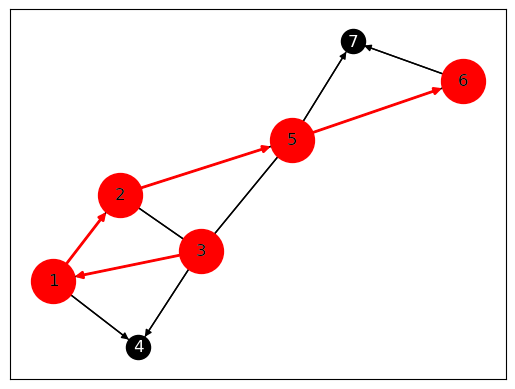

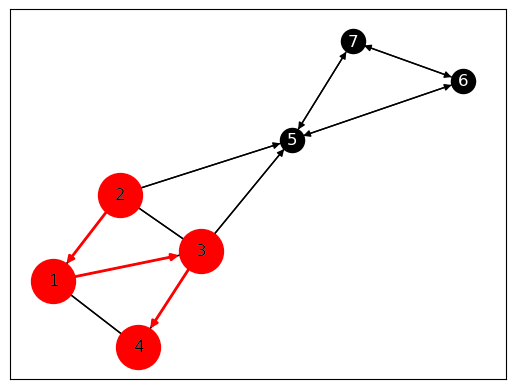

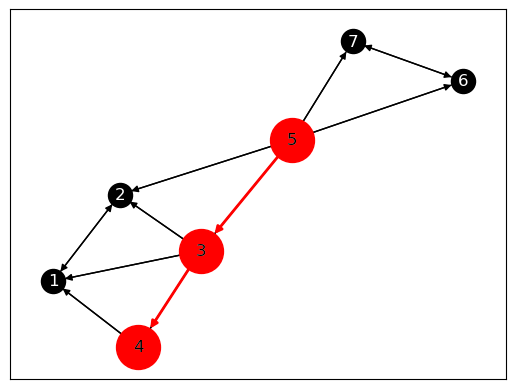

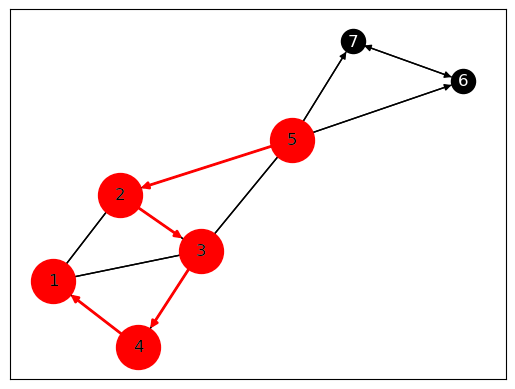

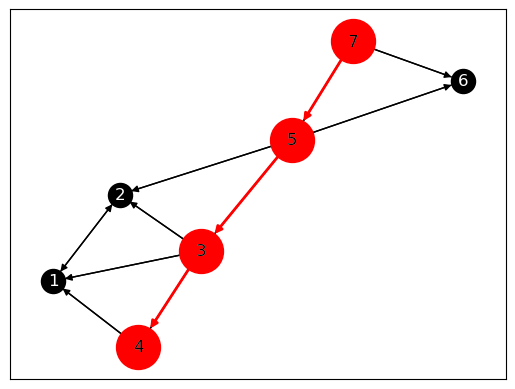

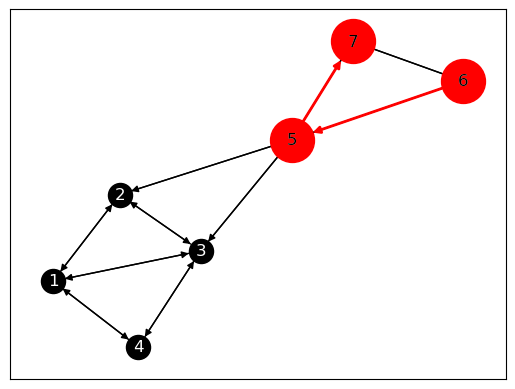

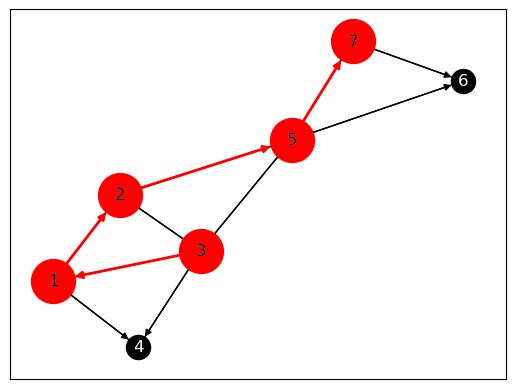

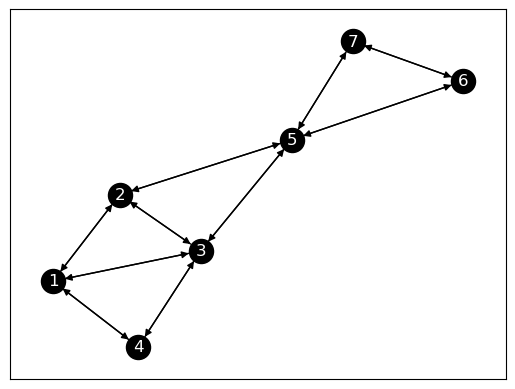

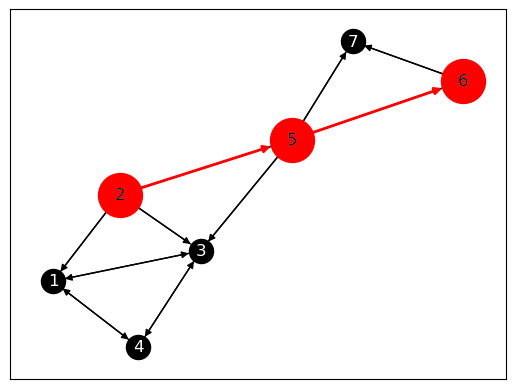

In [10]:
pos = nx.spring_layout(G)

subG = list()
for i in SFCs_links:
    subG.append(G.edge_subgraph(i))

for i in subG:
    nx.draw_networkx(G, pos=pos, node_color='k', edge_color='k', font_color='w', with_labels=True)
    nx.draw_networkx(i, pos=pos, node_color="r", node_size=1000, edge_color="r", width=2.0)
    plt.show()